# Governing Law Investigation


**Method:**

The base features for the ‘Governing Law’ clause are extracted from the CUAD data via the process outlined above.
For each base feature, punctuation will be removed; it will be converted to lower case; the NLTK stopwords with the addition of 'agreement', 'law', 'governed', 'laws', 'accordance' and 'hereto' will be removed ; any consecutive blank spaces that number two or more will be reduced to single space; and a token tidy process will be applied.  The token tidy process transforms elements of interest that would normally be expressed in two or more tokens into a single token.  For the ‘Governing Law’ investigation, the following will be transformed: 

'new york': 'newyork', 'new jersey':'newjersey', 'hong kong':'hongkong', 'san antonio':'sanantonio', 'los angeles':'losangeles', 'state israel':'israel', 'united states america':'usa', 'united states of america':'usa', 'united states':'usa'

The pre-processed base features will then be vectorized using Tf-Idf vectorization.  This has been chosen over count vectorisation in this process due to its ability to down weight commonly occurring terms within a corpus and find the features that drive differentiation.  The resulting feature space will be reduced to a 2D representation T-SNE with a fixed random state and then clustered using KMeans.  The effectiveness of the clustering will then be measured using the ‘Elbow’ method and the SSE and the S-DBW metrics.  

To determine the best parameter configuration and cluster number, we will again test a range of parameter configurations.  These will involve testing both unigrams and bigrams and a maximum features value drawn from 10, 15, 20 and None in the vectorization process and a range of clusters between 2 and 15 in the KMeans clustering.

The investigations that apply specialist knowledge to the ‘Governing Law’ clause will take a marginally different approach.  The same approach as above will be taken to extract the base features.

The base features will then provisionally only have multiple blank spaces reduced to single ones and white space at the end of the strings removed.  This is to ensure any features in the data that assist the Named Entity recognition algorithm (such as capitalization) are not lost.

The features resulting from the above are then processed to produce the new ‘hand crafted’ features that implicitly encode domain knowledge for the analysis.  This will utilize the knowledge that ‘Governing Law’ should be a country, state or similar and the technical knowledge that such items are named entities.

Each annotation is coerced to a true case capitalization via the truecase package in python.  This applies a statistical model trained on the NLTK English corpus to restore the proper capitalisation to an incorrectly capitalised text string [38], [39].  To further assist, any instances of 'peoples Republic of China' are manually coerced to 'Peoples Republic of China'.  For each annotation, the spaCy package is utilized with the pre trained English module to identify entities in the features.  If the label of the entity falls in to ‘GPE, ‘NORP’ ‘LANGUAGE’ of ‘ORG’ then (if it has not already been added) the text of the entity is added to the new feature for the contract. 

These new features then have the same pre-processing applied as in the provisional investigations and the same grid search conducted to identify the optimal parameter and cluster configuration. 

For both experiments, the labels for each class will be based on the top tokens found in the respective features and the ratio of the token to clauses in the respective class. 


## Section 1: Download Data & Extract Clause Of Interest

In [1]:
#Import required packages for section
import numpy as np

### 1:1 Download CUAD Data

In [2]:
#Import required packages for section
from DownloadCUAD import DownloadCUAD, clean_clause
from UsefulProjectFunctions import print_samples

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RichardWarburton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Download CUAD Data to local drive
DC = DownloadCUAD()
DC.setup()

CUAD data already downloaded & extracted!


### 1.2 Extract Specific Clauses & Output Clause Text Examples

In [4]:
#Extract annotations for specific clause and the coresponding contracts 
clause_of_interest = 'Governing Law'

#Concatenate string where there are multiple annotations.
contracts_GL,combined_annotations_GL = DC.extract_clause(clause_of_interest,True)

There are 437 contracts (85.69%) with 'Governing Law' annotations
There are 25 contracts with more than one annotation


In [5]:
print_samples(combined_annotations_GL)

5 Random samples from the data:

This Agreement and all disputes arising out of or related to this Agreement or any breach hereof shall be governed by and construed in accordance with the laws of the State of New York, without giving effect to any choice of law principles that would result in the application of the laws of any other jurisdiction. 

The construction, interpretation, and performance of this Agreement and all transactions under it shall be governed by the laws of the State of Texas, irrespective of its conflict of law principles. 

This Agreement takes effect upon its acceptance and execution by AIRSOPURE in the State of Texas, and shall be interpreted and construed under the laws of the State of Texas. 

All questions with respect to the construction of this Agreement, and the rights and liabilities of the Parties hereto, shall be governed by the laws of the State of Florida. 

This Agreement has been entered into in the State of Tennessee, and the validity, interpretati

## Section 2: Pre Process Data

The following applies the pre processing outlined in the method.  This uses a bespoke transformer to allow the different elements to be toggled efficently in the pipeline


In [6]:
#Define list of additional stop words to remove in addition to XXXXXX
additional_stop_words = ['agreement','law','governed','laws','accordance','hereto']

#Define dictionary of multiple words to treat as a single token (and remove spaces)
token_tidy = {'new york':'newyork',
             'new jersey':'newjersey',
             'hong kong':'hongkong',
             'san antonio':'sanantonio',
             'los angeles':'losangeles',
             'state israel':'israel',
             'united states america':'usa',
             'united states of america':'usa',
             'united states':'usa'}

In [7]:
#initate clause_clean class with paramaters set for specific problem
clean = clean_clause(punct=True,
                     lower=True,
                     stop_wd = True,
                     double_spaces= True,
                     strip=True,
                     additional_stop_words = additional_stop_words,
                     token_tidy = token_tidy)

GL_features = clean.fit_transform(combined_annotations_GL)

# Section 3: Vectorize & Clustering of Clause Data

### Section 3.1 TfIdf Vectorisation of Clause Text with KMeans Clustering

This investigates the application of simple NLP techniques to the clause text


In [8]:
#Import required packages for section
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from s_dbw import S_Dbw
from UsefulProjectFunctions import label_cluster,cluster_summary

In [9]:
#Initate dictionary to hold multiple vector representations
vector_representations = {}
TSNE_representations = {}
feature_spaces = {}
vocab = {}

#Define range of n_grams to investigate
n_gram_rng =[(1,1),(1,2)]
vectorisation_technique =['TfIdf']
max_features_rng = [10,15,20,None]

for approach in vectorisation_technique:
    for n_gram in n_gram_rng:
        for feats in max_features_rng:
        
            vect_method = {'count':CountVectorizer(ngram_range = n_gram,max_features = feats),
                           'TfIdf':TfidfVectorizer(ngram_range = n_gram,max_features = feats)}

            vectorizer = vect_method[approach]
            
            
            vector_representations[(approach,n_gram,feats)] = vectorizer.fit_transform(GL_features).toarray()
            TSNE_representations[(approach,n_gram,feats)] = TSNE(n_components=2,random_state = 42).fit_transform(vector_representations[(approach,n_gram,feats)])
            vocab[(approach,n_gram,feats)] = vectorizer.vocabulary_
        

In [10]:
#Define range of cluster values (k) to investigate
k_rng = np.arange(2,16,1)

#Initate dictionaries to store results in a list
results = defaultdict(list)
score = defaultdict(list)
clustering = {}

for key in TSNE_representations.keys():
    for k in k_rng:
        cluster = KMeans(n_clusters=k, random_state=42).fit(TSNE_representations[key])
        
        #Append results for respective k to results and score lists dictionaries with given key
        results[key].append(cluster.inertia_)
        score[key].append(S_Dbw(TSNE_representations[key], cluster.labels_, centers_id=None, 
                                method='Tong', alg_noise='bind',
                                centr='mean', nearest_centr=True,
                                metric='euclidean'))

        clustering[(key,k)] = cluster
    

In [11]:
#Select Choosen Parameters (Selected in advance to aid plotting)
"""Selected in advance for formatting of plot for report"""
choosen_params =('TfIdf',(1,1),10)
choosen_k = 6

#Extract choosen plot values
x_k = choosen_k
y_sse = np.array(results[choosen_params])[k_rng == choosen_k][0]
y_sdbw = np.array(score[choosen_params])[k_rng == choosen_k][0]

In [12]:
print('SSE score for optimal paramaters: {:.2f}'.format(y_sse))
print('S-DBW score for optimal paramaters: {:.2f}'.format(y_sdbw))

SSE score for optimal paramaters: 10127.65
S-DBW score for optimal paramaters: 0.25


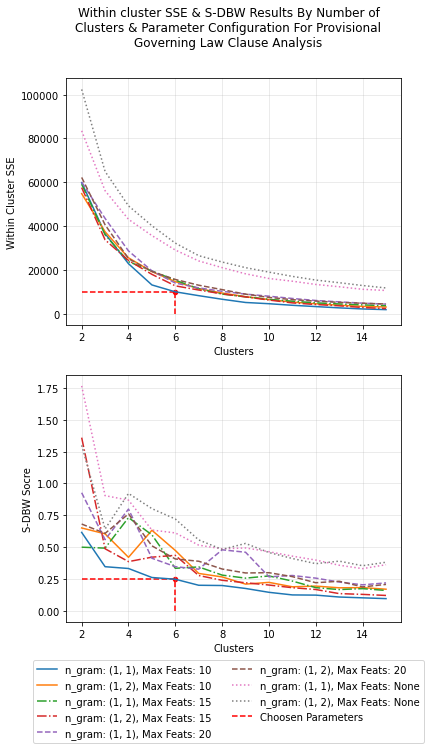

In [13]:
#Plot Results
fig, axs = plt.subplots(2, 1, figsize = (6,10))

lin_type ={10:'-',15:'-.',20:'--',None:':'}

for i in range(len(max_features_rng)):
    
    feats_to_plot = max_features_rng[i]
    
    for key in results.keys():
        if key[2] == feats_to_plot:
            
            axs[0].plot(k_rng, results[key],
                        label = 'n_gram: {1}, Max Feats: {2}'.format(*key),
                        linestyle = lin_type[feats_to_plot])
            
            axs[1].plot(k_rng, score[key],
                        label = 'n_gram: {1}, Max Feats: {2}'.format(*key),
                        linestyle = lin_type[feats_to_plot])

#Add chosen parmater call out to plot 0            
axs[0].scatter(x_k,y_sse,color = 'red',s = 20)
axs[0].vlines(x_k,ymin = 0, ymax = y_sse,color='red',linestyle='--',label ='Choosen Parameters')
axs[0].hlines(y_sse,xmin = 2, xmax = x_k,color='red',linestyle='--')

#Add chosen parmater call out to plot 1
axs[1].scatter(x_k,y_sdbw,color = 'red',s = 20)
axs[1].vlines(x_k,ymin = 0, ymax = y_sdbw,color='red',linestyle='--',label ='Choosen value')
axs[1].hlines(y_sdbw,xmin = 2, xmax = x_k,color='red',linestyle='--')

#format axs[0]            
axs[0].grid(alpha = 0.3)
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Within Cluster SSE')

axs[1].grid(alpha = 0.3)
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('S-DBW Socre')

fig.suptitle('Within cluster SSE & S-DBW Results By Number of\nClusters & Parameter Configuration For Provisional\nGoverning Law Clause Analysis',size = 12)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol = 2,bbox_to_anchor = (0.5,-0.05))
plt.savefig('Fig9.png',bbox_inches='tight')
plt.show()

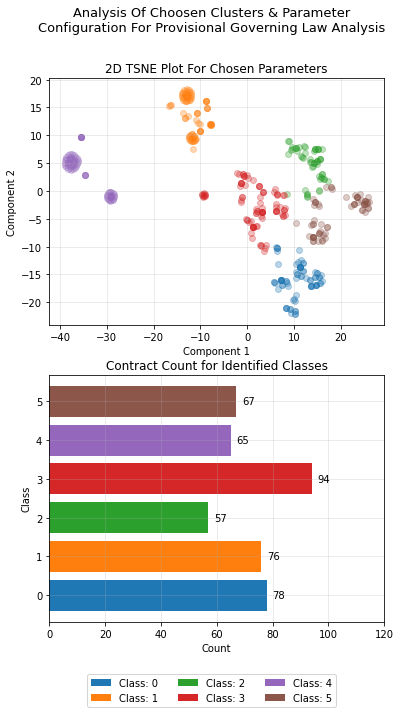

In [14]:
#Select Choosen Parameters
choosen_params =('TfIdf',(1,1),10)
choosen_k = 6

#Extract labels for chosen parameters
labs = clustering[(choosen_params,choosen_k)].labels_

#Determine label counts in clustered classes
classes,counts = np.unique(labs,return_counts=True)


#Plot Results
fig, axs = plt.subplots(2, 1, figsize = (6,10))

#Plot TSNE representation for chosen parameters
X = TSNE_representations[choosen_params]
for l in np.unique(labs):
    idx = labs == l
    c_idx = classes == l
    axs[0].scatter(X[:,0][idx],X[:,1][idx],alpha = 0.3, label = 'Class: {}'.format(l))
    axs[1].barh(classes[c_idx],counts[c_idx], label = 'Class: {}'.format(l))

#Format Plot
axs[0].set_title('2D TSNE Plot For Chosen Parameters')
axs[0].set_xlabel('Component 1')
axs[0].set_ylabel('Component 2')
axs[0].grid(alpha = 0.3)


axs[1].set_title('Contract Count for Identified Classes')
axs[1].grid(alpha = 0.3)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Class')
axs[1].set_xlim([0,120])

for i, v in enumerate(counts):
    axs[1].text(v+2,i,str(v),va='center', color='black')

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol = 3,bbox_to_anchor = (0.5,-0))

plt.suptitle('Analysis Of Choosen Clusters & Parameter\nConfiguration For Provisional Governing Law Analysis',size=13)
plt.show()

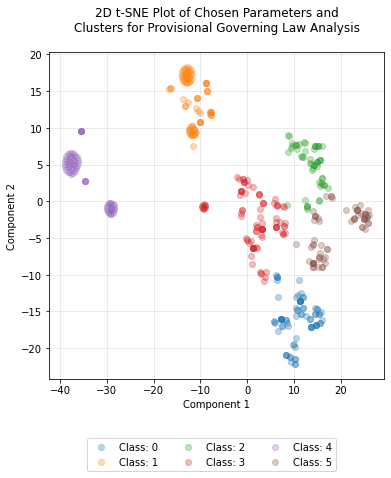

In [15]:
#Select Choosen Parameters
choosen_params =('TfIdf',(1,1),10)
choosen_k = 6

#Extract labels for chosen parameters
labs = clustering[(choosen_params,choosen_k)].labels_

#Determine label counts in clustered classes
classes,counts = np.unique(labs,return_counts=True)


#Plot Results
fig, axs = plt.subplots(figsize = (6,6))

#Plot TSNE representation for chosen parameters
X = TSNE_representations[choosen_params]
for l in np.unique(labs):
    idx = labs == l
    c_idx = classes == l
    axs.scatter(X[:,0][idx],X[:,1][idx],alpha = 0.3, label = 'Class: {}'.format(l))

#Format Plot
axs.set_xlabel('Component 1')
axs.set_ylabel('Component 2')
axs.grid(alpha = 0.3)

axs.set_title('2D t-SNE Plot of Chosen Parameters and\nClusters for Provisional Governing Law Analysis\n',size=12)
fig.legend(loc='lower center', ncol = 3,bbox_to_anchor = (0.5,-0.1))

plt.savefig('Fig10.png',bbox_inches='tight')
plt.show()

In [16]:
cluster_summary(counts)

Minimum cluster contract count is: 57
Maximum cluster contract count is: 94
Mean cluster contract count is: 72.83
Variance of cluster contract count is: 11.77


In [17]:
df = pd.DataFrame(label_cluster(GL_features,labs,3)).T
df.style.hide_index()

Class,Class Label,Token to Annotation Ratio
0,conflicts -- state -- without,0.949 -- 0.910 -- 0.833
1,state -- shall -- construed,1.342 -- 0.947 -- 0.618
2,state -- effect -- shall,1.123 -- 1.088 -- 0.860
3,state -- conflict -- shall,0.915 -- 0.904 -- 0.872
4,shall -- construed -- parties,1.046 -- 0.692 -- 0.185
5,newyork -- state -- shall,1.448 -- 1.388 -- 0.985


In [18]:
print('vocabulary used in the vectorization with choosen parameters:\n')

for v in vocab[choosen_params].keys():
    print(v)

vocabulary used in the vectorization with choosen parameters:

construed
state
effect
shall
without
conflicts
principles
conflict
newyork
regard


### Section 3.2: Applying Specialist Knowledge (Hand Crafted Features) and KMeans Clustering

This investigates the application of simple NLP techniques combined with specialist legal knowledge to the clause text

In [19]:
#Import packages required for the section
import spacy
from spacy import displacy
import en_core_web_sm
import geonamescache
import pandas as pd
import truecase

In [20]:
#Reset clause extraction to allow for differing pre processing needs
clean = clean_clause(punct=False,
                     lower=False,
                     stop_wd = False,
                     double_spaces= True,
                     strip=True)

GL_features = clean.fit_transform(combined_annotations_GL)

In [21]:
nlp = en_core_web_sm.load()
type_count = Counter()

#Build new features
new_features = []
not_mapped = []

#For each annotation inthe features
for annotation in GL_features:
    #Initate list of new features for annotation
    annotation_GPEs = []
    
    #Force correct capitalisation on annotation
    annotation = truecase.get_true_case(annotation)
    annotation = annotation.replace('peoples Republic of China','Peoples Republic of China')
    
    #Build the document for analysis
    doc = nlp(repr(annotation))
    
    #For each entity in the document
    for X in doc.ents:
        type_count[X.label_] += 1
        #Extract those with a GPE or Language label to new features
        #if X.label_ == 'GPE' or X.label_ == 'LANGUAGE':
        if X.label_ in ['GPE','NORP','LANGUAGE','ORG']:
            if X.text not in annotation_GPEs:
                annotation_GPEs.append(X.text)

                
    if annotation_GPEs == []:
        not_mapped.append(annotation)
            
        
    #Add list of all entitities found to new_features list
    new_features.append(' '.join(annotation_GPEs))

In [22]:
#Count number of annotations where a GPE or LANGUAGE has not been extracted
not_mapped_count = list(map(lambda x : 1 if x == '' else 0, new_features))

#Output mapping analysis
print('{} out of {} not mapped via process ({:.2%})'.format(*(sum(not_mapped_count),len(not_mapped_count),
                                                              sum(not_mapped_count)/len(not_mapped_count))))

11 out of 437 not mapped via process (2.52%)


In [23]:
pd.DataFrame(type_count.values(), index = type_count.keys(),columns=['NER Count'])

,NER Count
GPE,639
LANGUAGE,7
NORP,34
ORG,71
CARDINAL,12
DATE,26
ORDINAL,2
LAW,5
PERSON,35
LOC,1


In [24]:
#initate clause_clean class with paramaters set for specific problem
clean = clean_clause(punct=True,
                     lower=True,
                     stop_wd = True,
                     double_spaces= True,
                     strip=True,
                     additional_stop_words = additional_stop_words,
                     token_tidy = token_tidy)

new_features = clean.fit_transform(new_features)

for i in range(len(new_features)):
    if new_features[i] == '':
        new_features[i] ='nolocation'

In [25]:
#Initate dictionary to hold multiple vector representations
vector_representations_NER = {}
TSNE_representations_NER = {}
vocab_NER = {}

#Define range of n_grams to investigate
n_gram_rng =[(1,1),(1,2)]
vectorisation_technique =['TfIdf']
max_features_rng = [10,15,20,None]

for approach in vectorisation_technique:
    for n_gram in n_gram_rng:
        for feats in max_features_rng:
        
            vect_method = {'count':CountVectorizer(ngram_range = n_gram,max_features = feats),
                           'TfIdf':TfidfVectorizer(ngram_range = n_gram,max_features = feats)}

            vectorizer = vect_method[approach]
            
            
            vector_representations_NER[(approach,n_gram,feats)] = vectorizer.fit_transform(new_features).toarray()
            TSNE_representations_NER[(approach,n_gram,feats)] = TSNE(n_components=2,random_state = 42).fit_transform(vector_representations_NER[(approach,n_gram,feats)])
            
            vocab_NER[(approach,n_gram,feats)] = vectorizer.vocabulary_
        

In [26]:
#Initate dictionaries to store results in a list
results_NER = defaultdict(list)
score_NER = defaultdict(list)
clustering_NER = {}


for key in TSNE_representations_NER.keys():
    for k in k_rng:
        cluster = KMeans(n_clusters=k, random_state=42).fit(TSNE_representations_NER[key])
        
        #Append results for respective k to results and score lists dictionaries with given key
        results_NER[key].append(cluster.inertia_)
        score_NER[key].append(S_Dbw(TSNE_representations_NER[key], cluster.labels_, centers_id=None, 
                                method='Tong', alg_noise='bind',
                                centr='mean', nearest_centr=True,
                                metric='euclidean'))

        clustering_NER[(key,k)] = cluster


In [27]:
#Select Choosen Parameters
choosen_params_NER =('TfIdf',(1,2),10)
choosen_k_NER = 6

#Extract choosen plot values
x_k = choosen_k
y_sse = np.array(results_NER[choosen_params_NER])[k_rng == choosen_k_NER][0]
y_sdbw = np.array(score_NER[choosen_params_NER])[k_rng == choosen_k_NER][0]

In [28]:
print('SSE score for optimal paramaters: {:.2f}'.format(y_sse))
print('S-DBW score for optimal paramaters: {:.2f}'.format(y_sdbw))

SSE score for optimal paramaters: 2820.51
S-DBW score for optimal paramaters: 0.07


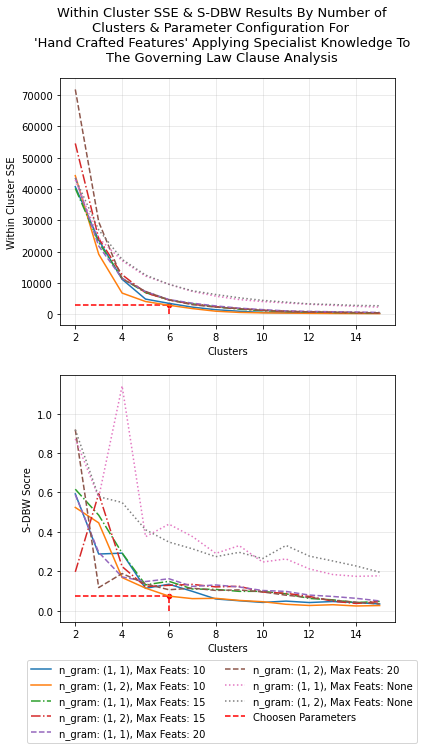

In [29]:
#Plot Results
fig, axs = plt.subplots(2, 1, figsize = (6,10))

lin_type ={10:'-',15:'-.',20:'--',None:':'}

for i in range(len(max_features_rng)):
    
    feats_to_plot = max_features_rng[i]
    
    for key in results_NER.keys():
        if key[2] == feats_to_plot:
            
            axs[0].plot(k_rng, results_NER[key],
                        label = 'n_gram: {1}, Max Feats: {2}'.format(*key),
                        linestyle = lin_type[feats_to_plot])
            
            axs[1].plot(k_rng, score_NER[key],
                        label = 'n_gram: {1}, Max Feats: {2}'.format(*key),
                        linestyle = lin_type[feats_to_plot])
            
#Add chosen parmater call out to plot 0            
axs[0].scatter(x_k,y_sse,color = 'red',s = 20)
axs[0].vlines(x_k,ymin = 0, ymax = y_sse,color='red',linestyle='--',label ='Choosen Parameters')
axs[0].hlines(y_sse,xmin = 2, xmax = x_k,color='red',linestyle='--')

#Add chosen parmater call out to plot 1
axs[1].scatter(x_k,y_sdbw,color = 'red',s = 20)
axs[1].vlines(x_k,ymin = 0, ymax = y_sdbw,color='red',linestyle='--',label ='Choosen value')
axs[1].hlines(y_sdbw,xmin = 2, xmax = x_k,color='red',linestyle='--')

#format axs[0]            
axs[0].grid(alpha = 0.3)
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Within Cluster SSE')

axs[1].grid(alpha = 0.3)
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('S-DBW Socre')

fig.suptitle('Within Cluster SSE & S-DBW Results By Number of\nClusters & Parameter Configuration For \n\'Hand Crafted Features\' Applying Specialist Knowledge To\nThe Governing Law Clause Analysis',size = 13)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol = 2,bbox_to_anchor = (0.5,-0.05))
plt.savefig('Fig11.png',bbox_inches='tight')

plt.show()

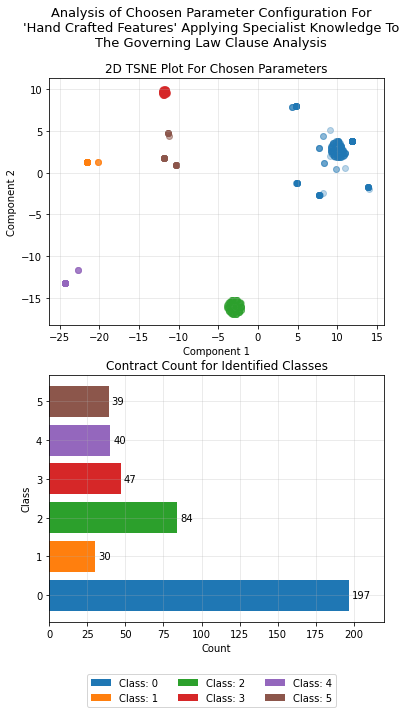

In [30]:
#Select Choosen Parameters
choosen_params_NER =('TfIdf',(1,2),10)
choosen_k_NER = 6

#Extract labels for chosen parameters
labs = clustering_NER[(choosen_params_NER,choosen_k_NER)].labels_

#Determine label counts in clustered classes
classes,counts = np.unique(labs,return_counts=True)


#Plot Results
fig, axs = plt.subplots(2, 1, figsize = (6,10))

#Plot TSNE representation for chosen parameters
X = TSNE_representations_NER[choosen_params_NER]
for l in np.unique(labs):
    idx = labs == l
    c_idx = classes == l
    axs[0].scatter(X[:,0][idx],X[:,1][idx],alpha = 0.3, label = 'Class: {}'.format(l))
    axs[1].barh(classes[c_idx],counts[c_idx], label = 'Class: {}'.format(l))

#Format Plot
axs[0].set_title('2D TSNE Plot For Chosen Parameters')
axs[0].set_xlabel('Component 1')
axs[0].set_ylabel('Component 2')
axs[0].grid(alpha = 0.3)


axs[1].set_title('Contract Count for Identified Classes')
axs[1].grid(alpha = 0.3)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Class')
axs[1].set_xlim([0,220])

for i, v in enumerate(counts):
    axs[1].text(v+2,i,str(v),va='center', color='black')

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol = 3,bbox_to_anchor = (0.5,-0))

plt.suptitle('Analysis of Choosen Parameter Configuration For\n\'Hand Crafted Features\' Applying Specialist Knowledge To\nThe Governing Law Clause Analysis',size=13)
plt.show()

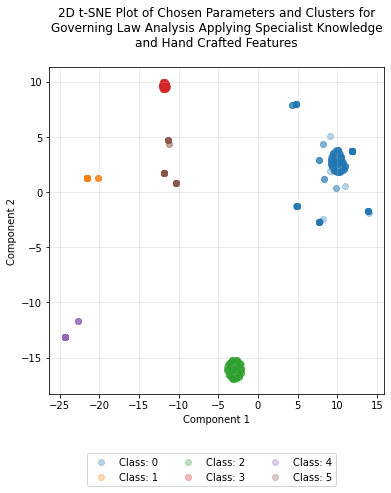

In [31]:
#Select Choosen Parameters
choosen_params_NER =('TfIdf',(1,2),10)
choosen_k_NER = 6

#Extract labels for chosen parameters
labs = clustering_NER[(choosen_params_NER,choosen_k_NER)].labels_

#Determine label counts in clustered classes
classes,counts = np.unique(labs,return_counts=True)


#Plot Results
fig, axs = plt.subplots(figsize = (6,6))

#Plot TSNE representation for chosen parameters
X = TSNE_representations_NER[choosen_params_NER]
for l in np.unique(labs):
    idx = labs == l
    c_idx = classes == l
    axs.scatter(X[:,0][idx],X[:,1][idx],alpha = 0.3, label = 'Class: {}'.format(l))

#Format Plot
axs.set_xlabel('Component 1')
axs.set_ylabel('Component 2')
axs.grid(alpha = 0.3)

axs.set_title('2D t-SNE Plot of Chosen Parameters and Clusters for\nGoverning Law Analysis Applying Specialist Knowledge\nand Hand Crafted Features\n',size=12)
fig.legend(loc='lower center', ncol = 3,bbox_to_anchor = (0.5,-0.1))
plt.savefig('Fig12.png',bbox_inches='tight')
plt.show()

In [32]:
#Output summay caluse analysis
cluster_summary(counts)

Minimum cluster contract count is: 30
Maximum cluster contract count is: 197
Mean cluster contract count is: 72.83
Variance of cluster contract count is: 58.12


In [33]:
#Output labling analysis for the process
df = pd.DataFrame(label_cluster(new_features,labs,3)).T
df.style.hide_index()

Class,Class Label,Token to Annotation Ratio
0,commonwealth -- florida -- pennsylvania,0.122 -- 0.096 -- 0.071
1,texas -- usa -- county,1.033 -- 0.167 -- 0.133
2,newyork -- united -- nations,1.024 -- 0.024 -- 0.024
3,california -- losangeles -- loco,1.000 -- 0.043 -- 0.021
4,delaware -- usa -- america,1.000 -- 0.125 -- 0.025
5,usa -- newyork -- california,1.026 -- 0.385 -- 0.256


In [34]:
print('vocabulary used in the vectorization with choosen parameters:\n')

for v in vocab_NER[choosen_params_NER].keys():
    print(v)

vocabulary used in the vectorization with choosen parameters:

florida
texas
newyork
commonwealth
delaware
usa
pennsylvania
commonwealth pennsylvania
california
england


### Section 3.3 Random Samples for Appendicies

In [35]:
#Class 5 Random samples
idx = labs == 5
print_samples(combined_annotations_GL[idx])

5 Random samples from the data:

This Agreement will be governed by and interpreted in accordance with the local laws of the State of Washington, U.S.A., without regard to its conflicts of law provisions and not including the provisions of the 1980 U.N. Convention in Contracts for the International Sale of Goods. 

This Agreement shall be construed and enforced in accordance with, and the rights of the parties shall be governed by, the laws of the State of New York and the laws of the United States applicable therein. 

This Agreement shall be governed by the laws of the State of California, USA, excluding conflict of laws provisions and excluding the 1980 United Nations Convention on Contracts for the International Sale of Goods. 

This Agreement shall be governed by and construed in accordance with the laws of the State of Connecticut, U.S.A. without regard to its conflict of taws provision. 

This Agreement and its application and interpretation will be governed exclusively by its t

In [36]:
#Class 0 Random samples
idx = labs == 0
print_samples(combined_annotations_GL[idx])

5 Random samples from the data:

Even in case of agreements with foreign (non-German) Software Publishers and Affiliates, the law of the Federal Republic of Germany applies. 

South Dakota This Agreement shall be construed in accordance with and governed by the laws of the State of South Dakota. 

This Agreement shall be governed by and construed in accordance with the laws of the State of Ohio, without reference to principles of conflicts of law. 

This Agreement, its interpretation and construction, and the remedies for its enforcement or breach are to be applied in accordance with the laws of the State of New Jersey. 

This Agreement and all related business transactions will be governed by the laws of the Commonwealth of Massachusetts (without reference to principles of conflicts or choice of law which would cause the application of the internal laws of any other jurisdiction). 

